Marcin Wardyński  
czwartek, 8:00

## Lab 2

Używam zdockeryzowanego Elasticsearch z repozytorium i zakładam, że przed wykonaniem jakichkolwiek zapytań kontener ten zostanie uruchomiony.

Definiuję nazwę indeksu oraz adres url Elastichsearch:

In [104]:
es_url = "http://localhost:9200"
index_name = "mw_nlp_lab2"

index_url = F"{es_url}/{index_name}"

Usuwam indeks, jeśli już istniał:

In [ ]:
import requests

delete_response = requests.delete(f"{index_url}")

# Check if the deletion was successful
if delete_response.status_code == 200:
    print(f"Index '{index_name}' deleted successfully.")
else:
    print(f"Failed to delete index '{index_name}': {delete_response.text}")

Index 'mw_nlp_lab2' deleted successfully.


Listuję istniejące indeksy, żeby sprawdzić skuteczność usunięcia indeksu.

In [106]:
import requests

index_list_response = requests.get(f"{es_url}/_cat/indices?format=json")
index_list_response.content

b'[]'

Tworzę indeks na dokumenty ze zbioru FiQA-PL, oraz analizatory zgodnie z poleceniem 3, 4 i 5.
Różne analizatory definiuję na poziomie pól wewnętrzenych pola `text`, co pozwala zdefiniować tylko pole nadrzędne przy indeksowaniu danych.

In [ ]:
import requests
import json

fiqa_index_settings = {
    "settings": {
        "analysis": {
            "filter": {
                "polish_months_synonym": {
                    "type": "synonym",
                    "synonyms": [
                        "kwiecień, kwi, IV",
                    ]
                },
                "polish_morfologik": {
                    "type": "morfologik_stem"
                }
            },
            "analyzer": {
                "polish_analyzer_syn_morf": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "filter": [
                        "lowercase",
                        "polish_months_synonym",
                        "polish_morfologik",
                        "lowercase"
                    ]
                },
                "polish_analyzer_nsyn_morf": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "filter": [
                        "lowercase",
                        "polish_morfologik",
                        "lowercase"
                    ]
                }
            }
        }
    },
    "mappings": {
        "properties": {
            "text": {
                "type": "text",
                "fields": {
                    "analyzed_1": {
                        "type": "text",
                        "analyzer": "polish_analyzer_syn_morf"
                    },
                    "analyzed_2": {
                        "type": "text",
                        "analyzer": "polish_analyzer_nsyn_morf"
                    }
                }
            }
        }
  }
}

response = requests.put(index_url, headers={"Content-Type": "application/json"}, data=json.dumps(fiqa_index_settings))
if response.status_code == 200:
    print("Index created.")
else:
    print(f"Index creation failed: {response.text}")


Index created.


Ładuję dane do indeksu w formie pojedyńczego batcha:

In [108]:
from datasets import load_dataset

fiqa_dataset = load_dataset("clarin-knext/fiqa-pl", name="corpus")

bulk_data = ""
for entry in fiqa_dataset["corpus"]:
    doc_id = entry["_id"]
    bulk_data += json.dumps({"index": {"_index": index_name, "_id": doc_id}}) + "\n"
    bulk_data += json.dumps({"text": entry['text']}) + "\n"

        

bulk_response = requests.post(f"{es_url}/_bulk", headers={"Content-Type": "application/x-ndjson"}, data=bulk_data)

if bulk_response.status_code == 200:
    response_data = bulk_response.json()
    if any(item.get("index", {}).get("error") for item in response_data["items"]):
        print("Some documents failed to index:")
        for item in response_data["items"]:
            if "error" in item["index"]:
                print(item["index"]["error"])
    else:
        print("All documents indexed successfully.")
else:
    print(f"Failed to index data: {bulk_response.text}")

All documents indexed successfully.


Punkt 7: Znajduję liczbę dokumentów oraz dopasowań dla słowa "kwiecień".  
Do wyszukania dokumentów wystarczy wywołać endpoint `/_search`, natomiast dla znalezienia ilości dopasowań przekazuję w zapytaniu parametr `highlight`, który instruuje Elasticsearch w celu zaznaczenia poszukiwanej frazy w znalezionych dokumentach. Po zliczeniu i zsumowaniu "zakreślonych" fraz, uzyskujemy kompletną liczbę dopasowań.

In [179]:
search_word = "kwiecień" 
search_field = "text.analyzed_1"

max_docs_no = 1000
max_highlights_no = 100

search_query = {
    "size": max_docs_no,
    "query": {
        "match": {
            search_field: search_word
        }
    },
    "highlight": {
        "fields": {
            search_field: {
                "type": "plain",
                "fragment_size": 0,
                "number_of_fragments": max_highlights_no
            }
        }
    }
}

response = requests.get(f"{index_url}/_search", headers={"Content-Type": "application/json"}, data=json.dumps(search_query))

docs_found = set([])

if response.status_code == 200:
    search_results = response.json()
        
    matches_counter = 0
    for hit in search_results["hits"]["hits"]:
        docs_found.add(hit['_id'])
        matches_counter += len(hit['highlight'][search_field])

    print(f"Found {search_results['hits']['total']['value']} documents and {matches_counter} matches of '{search_word}' in {search_field}.")
else:
    print(f"Search failed: {response.text}")


Found 306 documents and 439 matches of 'kwiecień' in text.analyzed_1.


Powyższy kod zwraca przy wyszukiwaniu z synoniami 306 dokumentów i 439 dopasowania. Namiast bez synonimów 257 dokumentów i 353 dopasowania.

W poprzednim laboratorium mieliśmy za zadanie utworzyć wyrażenie regularne, które znajduje "kwiecień" w pełnej odmianie przez przypadki obydwu liczb. Poniżej użyję tego kodu jeszcze raz, żeby sprawdzić, jak się mają jego wyniki do wynikamów analizatora bez synonimów. (Porównanie z synonimami nie ma większego sensu, gdyż wyrażenie regularne nie miało ich uwzględniać).

In [176]:
import regex

corpus = fiqa_dataset['corpus']

april_p = r"kwie(cień|tni)"
april_pattern = regex.compile(april_p, flags=regex.IGNORECASE | regex.MULTILINE)

def count_april_occurrences(what, pattern):
    occurrences = {}
    counter = 0

    for entry in corpus:
        found = regex.findall(pattern, entry['text'])
        
        counter += len(found)
        if found:
            occurrences[entry["_id"]] = len(found)

        
        
    print(f"{what} found in {len(occurrences.keys())} documents in total {counter} times.")
    return occurrences


occ_april = count_april_occurrences("'Kwiecien' (directly)", april_pattern)
regex_docs_found = occ_april.keys()

'Kwiecien' (directly) found in 265 documents in total 362 times.


Widać różnicę zarówno w ilości dokumentów, jak i dopasowań. Sprawdźmy skąd ona wynika poprzez obiczenie różnicy zbiorów dokumentów dostarczonych Elasticsearch oraz wyrażenie regularne:

In [111]:
docs_found-regex_docs_found

set()

Jak widać, nie ma dokumentów ze słowem bazującym na "kwiecień", które by zostało znalezione przez Elasticsearch, ale nie przez wyrażenie regularne.  
Wykonajmy różnicę zbiorów w odwrotnej kolejności.

In [173]:
regex_docs_found-docs_found

{'109292', '159500', '166563', '208216', '265866', '441143', '469888', '82284'}

Istnieje osiem dokumentów odnalezionych przez wyrażenie regularne, ale nie przez FTS. Po przyglądnięciu się zawartości tych dokumentów można stwierdzić, że różnica w wynikach bierze się z faktu, iż wyrażenie regularne zostało sformuowane dość luźno, przez co znajduje przymiotnik od rzeczownika "kwiecień", czyli "kwietniowy", wraz z jego pełną fleksją.

Poniższy kod pobiera zbiór par QA dla FiQA-PL i używając podzbioru `test` przygotowuje bazowe struktury do obliczenia metryki NDCG.

W tym celu przygotowany zostanie słownik prowadzący od zapytania, do pożądanych w odpowiedzi dokumentów, wraz z punktacją ich istotności, oraz lista zapytań które mają zdefiniowane pożądane wyniki, gdyż tylko dla nich jesteśmy w stanie obliczyć NDCG.

In [180]:
from datasets import load_dataset

def prepare_fiqa_qrels():
    subset = 'test'
    query_to_corpus_dict = {}

    qrels_dataset = load_dataset("clarin-knext/fiqa-pl-qrels")

    for item in qrels_dataset[subset]:
        if item['query-id'] not in query_to_corpus_dict:
            query_to_corpus_dict[item['query-id']] = {}

        query_to_corpus_dict[item['query-id']][item['corpus-id']] = item['score']

    for query_id in query_to_corpus_dict:
        sorted_corpuses_by_score = dict(sorted(query_to_corpus_dict[query_id].items(), key=lambda item: item[1]))
        query_to_corpus_dict[query_id] = sorted_corpuses_by_score

    return query_to_corpus_dict

def prepare_existing_fiqa_queries(query_to_corpus_dict):
    queries_dict = {}

    fiqa_dataset_queries = load_dataset("clarin-knext/fiqa-pl", name="queries")

    queries_dataset = fiqa_dataset_queries['queries']
    for entry in queries_dataset:
        if int(entry['_id']) in query_to_corpus_dict.keys():
            queries_dict[int(entry['_id'])] = entry['text']

    return queries_dict


query_to_corpus_dict = prepare_fiqa_qrels()
queries_dict = prepare_existing_fiqa_queries(query_to_corpus_dict)

W jednym z zapytań musimy nadpisać na czaz zapytania analizator, który został zdefiniowany na poziomie indeksu. W tym celu definiuję ten analizator, ale nie mapuję go do żadnego z pól dokumentu.

Jak widać, po usunięciu analizatora morfologicznego, oraz towarzyszącego mu dodatkowego filtra zmniejszającego litery po lematyzacji tokenów, zestaw filtrów pozostałych w analizatorze nie niesie ze sobą większej warości. W tokenach zostanie zmieniona wielkość liter na małe, co faktycznie jest przydatne, ale właściwie to wszystko, gdyż skonfigurowany zestaw synonimów nie będzie miał większego wpływu na przebieg tego ćwiczenia.

In [181]:
settings_payload = {
    "analysis": {
        "analyzer": {
            "polish_analyzer_syn_nmorf": {
                "type": "custom",
                "tokenizer": "standard",
                "filter": [
                    "lowercase",
                    "polish_months_synonym"
                ]
            }
        }
    }
}

requests.post(f"{index_url}/_close")
settings_response = requests.put(f"{index_url}/_settings", json=settings_payload)
if settings_response.status_code == 200:
    print("Analyzer added to settings successfully.")
else:
    print(f"Failed to update settings: {settings_response.text}")
requests.post(f"{index_url}/_open")

Analyzer added to settings successfully.


<Response [200]>

Poniżej przygotowałem funkcję, która opakowuje wywołanie wyszukiwania w Elasticsearch. Można za jej pomocą wybrać poszukiwaną frazę, przeszukiwane pole oraz nadpisać domyślny analizator.

In [206]:
dcg_limit = 5

def find_for_phrase(search_phrase, search_field, custom_analyzer):
    search_query = {
        "size": dcg_limit,
        "query": {
            "match": {
                search_field: {
                    "query": search_phrase,
                }
            }
        }
    }

    if custom_analyzer:
        search_query['query']['match'][search_field]['analyzer'] = custom_analyzer

    response = requests.get(f"{index_url}/_search", headers={"Content-Type": "application/json"}, data=json.dumps(search_query))

    if response.status_code == 200:
        search_results = response.json()
        return dict(list(map(lambda hit: (int(hit['_id']), float(hit['_score'])), search_results["hits"]["hits"])))
    else:
        print(f"Search failed: {response.text}")

Poniższy zestaw funkcji oblicza współczynnik NDCG@5 oraz przedstawia wyniki w formie średnich wartości, oraz wizualizuje rozkład wartości NDCG@5 na wykresach.

In [220]:
import math

relevant_doc_number = 0
relevant_docs = []

def calculate_dcg(docs, docs_scoring):
    sum = 0
    relevant_doc_id = None
    for i, doc_id in enumerate(docs):
        if doc_id in docs_scoring.keys():
            sum += (2**docs_scoring[doc_id]-1)/(math.log2(i+1+1))
            if i == relevant_doc_number:
                relevant_doc_id = doc_id
    return sum, relevant_doc_id

def calculate_ndcgs(search_field, custom_analyzer):
    
    ndcgs = []

    for q_id, q_text in queries_dict.items():
        ideal_search = list(query_to_corpus_dict[q_id].keys())[:dcg_limit]
        idcg, _ = calculate_dcg(ideal_search, query_to_corpus_dict[q_id])

        real_search_with_scores = find_for_phrase(q_text, search_field, custom_analyzer)
        dcg, relevant_doc_id = calculate_dcg(real_search_with_scores.keys(), query_to_corpus_dict[q_id])

        ndcgs.append(dcg/idcg)

        if relevant_doc_id:
            relevant_docs.append((relevant_doc_id, real_search_with_scores[relevant_doc_id], real_search_with_scores.values(), q_text))

    return ndcgs

import matplotlib.pyplot as plt
import numpy as np
def present_results(ndcgs):

    zeros = []
    non_zeros = []

    for ndcg in ndcgs:
        if ndcg == 0:
            zeros.append(ndcg)
        else:
            non_zeros.append(ndcg)

    labels = ['>0 Results', '0 Results']
    sizes = [len(non_zeros), len(zeros)]

    plt.pie(sizes, labels=labels, autopct='%1.1f%%')
    plt.title('NDCG@5 Results Proportion: 0 to >0')
    plt.show()

    plt.hist(non_zeros, bins=10, edgecolor='black')
    plt.title("Histogram of Non-Zero NDCG@5")
    plt.xlabel("Score")
    plt.ylabel("Number of Documents")
    plt.show()

    print(f"NDCG@5 Mean: {np.mean(ndcgs)} and Std: {np.std(ndcgs)}")
    print(f"NDCG@5 > 0 Mean: {np.mean(non_zeros)} and Std: {np.std(non_zeros)}")



Pierwsze wywołanie funkcji obliczającej NDCG@5 zostanie wykonane dla pola `text.analyzed_1`, które to uwzględnia synonimy i zawiera tokeny poddane lematyzacji.

Widzimy dość słabe wyniki NDCG@5, gdyż prawie 2/3 rezultatów wyszukiwania zostały ocenione na 0. Jest to spowodowane dość agresywnym odcinaniem wyników z Elasticsearch po pięciu najlepszych trafienia. Problem w tym, że nawet w przypadku pola `text.analyzed_1`, które w największej mierze obfituje w zaaplikwane filtry, stopień przygotowania tekstu do FTS jest dość słaby. W moim mniemaniu, przede wszystkim brakuje tu filtra typu `stop-words`, który pozwoliłby na skupieniu się podczas wyszukiwania na prawdziwie istotnych wyrazach wyrażenia.  
Bez użycia bardziej zaawansowanego przetwarzania tokenów, pożądane dokumenty są zapewne odnajdowane, lecz niestety giną wśród dopasowań mniej istotych wyrazów, przez co najczęściej nie kwalifikują się do TOP5 wyników, na podstawie których obliczane jest NDCG@5.

Wśród dokumentów, które otrzymały ocenę NDCG@5 większą niż 0, widać sporą grupę dokumentów odpowiadających idealnemu wyszukiwaniu, ale jeszcze większa liczba dokumentów otrzymała ocenę w okolicy 0.6 i 0.33.  
Średnia dla pozytywnych wyników wypada przy wartości 0.53, a odchylenie standardowe wynosi ok 0.26. Wartości te wskazują na całkie spory rozrzut wartości mierząc od środka przyjętej skali.

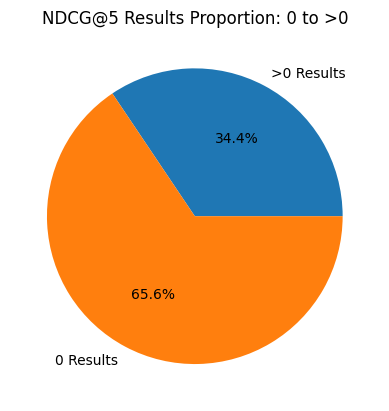

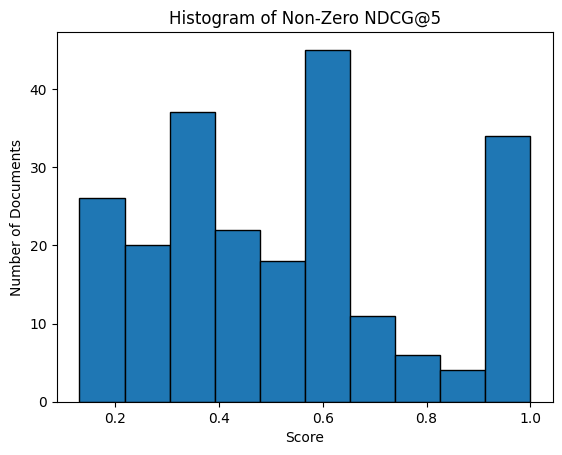

NDCG@5 Mean: 0.1851291130797741 and Std: 0.2968688062149335
NDCG@5 > 0 Mean: 0.5379536559448144 and Std: 0.2574697485799596


In [221]:
ndcgs = calculate_ndcgs('text.analyzed_1', "")
present_results(ndcgs)

Poniżej przedstawiam obliczone metryki NDCG@5 dla pola `text.analyzed_2`, które pomija użycie synonimów. Wyniki są identyczne z tymi, które otrzymałem przy uwzględnieniu synonimów, co potwierdza moje wcześniejsze założenie na temat nieistotności tego filtra w tym zadaniu.

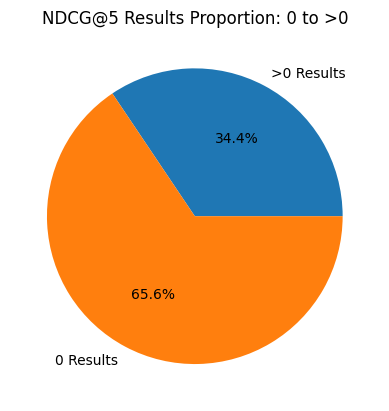

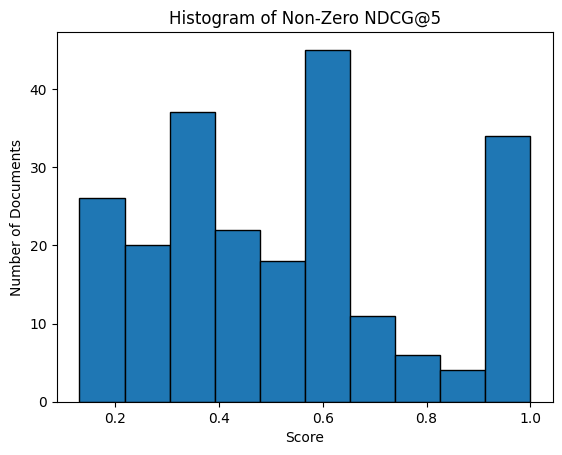

NDCG@5 Mean: 0.1851291130797741 and Std: 0.2968688062149335
NDCG@5 > 0 Mean: 0.5379536559448144 and Std: 0.2574697485799596


In [170]:
ndcgs = calculate_ndcgs('text.analyzed_2', "")
present_results(ndcgs)

Ostatecznie nadpisuję używany zestaw filtrów, filtrowaniem tymczasowym, które nie wykonuje lematyzacji tokenów przy zapytaniu.

Już przed wykonaniem tego polecenia należałoby się spodziewać dość słabych wyników, gdyż pole użyte do wyszukiwania bazuje na zlematyzowanych tokenach, natomiast wyszukiwana fraza nie. Taka rozbieżność prowadzi do małej liczby dopasowań, gdyż tylko frazy w których tokeny mają bezpośdrednią formę lematów mają szansę na odnalezienie dopasowań.  
W przypadu porzucenia lematyzacji podczas zapytania, zasadnym byłoby porzucenie jej również przy inksowaniu.

Prezentowane poniżej wyniki przedstawiają, że jedynie 15% dokumentów otrzymało ocenę wyższą od 0. Wśród pozytywnych wyników i tym razem nie brakuje idealnych trafień, jednakże histogram pokazuje większość dopasowań z oceną 0.6, a także ok 0.1-0.33.  
Średnia dla pozytywnych ocen jest niższa, niż w poprzednim podpunkcie i wynosi 0.52, natomiast odchylenie standardowe jest większe i z wartością 0.28 wskazuje na spore rozproszeni przyznanych ocen w metryce NDGC. 

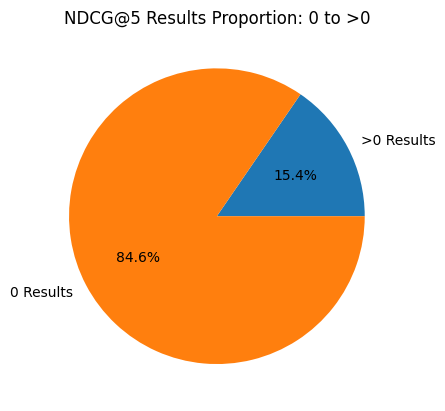

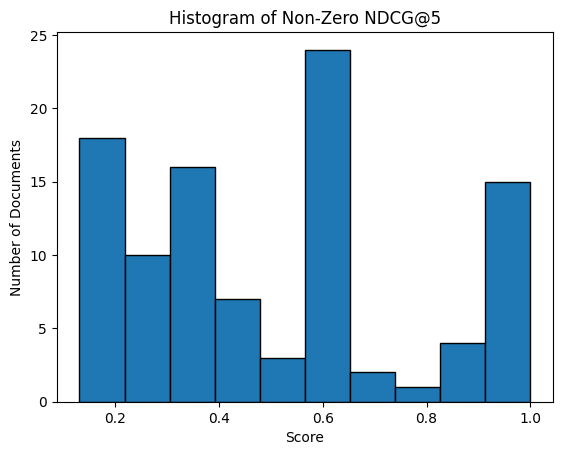

NDCG@5 Mean: 0.07962045797605899 and Std: 0.2156011491971515
NDCG@5 > 0 Mean: 0.5159405676848623 and Std: 0.2758625360069333


In [171]:
ndcgs = calculate_ndcgs('text.analyzed_1', "polish_analyzer_syn_nmorf")
present_results(ndcgs)

##### Sprawdzanie istotnych dokumentów na konkretnych pozycjach w wynikach

**Pozycja 1.**

In [222]:
relevant_docs[0]

(131996,
 27.351522,
 dict_values([27.351522, 21.07628, 20.436228, 18.99711, 18.589794]),
 'Jaka jest różnica między „handlowcem” a „maklerem giełdowym”?')

Zapytanie: "Jaka jest różnica między „handlowcem” a „maklerem giełdowym”?",

Score dokumentu: 27.35  
Score dokumentów z TOP 5: [27.351522, 21.07628, 20.436228, 18.99711, 18.589794]

Tekst dokumentu:  
"Handlowcy zarabiają na życie, maklerzy giełdowi mówią ludziom, aby angażowali się w transakcje na życie. Aby zostać zatrudnionym jako trader, potrzebujesz udokumentowanego doświadczenia w zakresie konsekwentnego zarabiania pieniędzy. Aby być zatrudnionym jako makler giełdowy, musisz uzyskać licencję, ale nie musisz udowadniać, że możesz konsekwentnie zarabiać pieniądze."

Widać ewidentnie, że wyrażenia z zapytania, typu "handlowiec" i "makler giełdowy", występują w odnalezionym zapytaniu, ale również słówka pomocnicze, jak "jaka-jako". Podobieństwo to dobrze odzwierciedla score o wartości 27.35.

**Pozycja 5.**

In [217]:
relevant_docs[0]

(64263,
 24.981318,
 dict_values([27.668133, 26.61875, 26.554457, 25.088612, 24.981318]),
 'Dlaczego stacje benzynowe pobierają różne kwoty w tej samej okolicy?')

Zapytanie: "Dlaczego stacje benzynowe pobierają różne kwoty w tej samej okolicy?"

Score dokumentu: 24.981318  
Score dokumentów z TOP5: [27.668133, 26.61875, 26.554457, 25.088612, 24.981318]

Tekst dokumentu:  
"„Jest to znane jako „Ceny strefowe” lub „Ceny geograficzne”. http://articles.latimes.com/2005/jun/19/business/fi-calprice19 Takie różnice cen mogą wydawać się dziwne, ale są nie tylko w Anaheim. Każdego dnia, w dowolnym większym mieście w USA, jedna marka benzyny będzie sprzedawana w szerokim zakresie cen, nawet jeśli koszty produkcji i dostawy paliwa są takie same. Głównym winowajcą są ceny strefowe, tajna i wszechobecna strategia koncernu naftowego polegająca na zwiększaniu zysków poprzez pobieranie od dealerów różnych kwot za paliwo w zależności od natężenia ruchu, udogodnień na stacji, dochodów gospodarstw domowych w pobliżu, siły konkurentów itp. Jest to kontrowersyjna strategia, ale jak dotąd sądy uznały ją za legalne, a Federalna Komisja Handlu stwierdziła niedawno, że wpływ na konsumentów był niejednoznaczny, ponieważ niektórzy klienci ucierpieli z powodu wyższych cen, podczas gdy inni skorzystali z niższych. http://en.wikipedia.org/wiki/Geographical_pricing przemysł benzynowy w Stanach Zjednoczonych s, to wycena benzyny oparta na złożonej i tajnej wadze czynników, takich jak liczba konkurujących stacji, liczba pojazdów, średni przepływ ruchu, gęstość zaludnienia i charakterystyka geograficzna. Może to spowodować, że dwie markowe stacje benzynowe oddalone od siebie o zaledwie kilka mil sprzedają benzynę w cenie nawet 0,50 USD za galon. Ale krótka odpowiedź brzmi „ponieważ mogą”. Jest to legalne, pod warunkiem, że niektórzy płacą mniej, a inni więcej. Zasadniczo większa, bogatsza publiczność subsydiuje produkt w innych obszarach. Nie różni się to strasznie od sposobu, w jaki wycenia się większość leków na świecie”."

Porównując zapytanie z tekstem dokumentu widać wyraźnie, że wiele słówek z zapytania powtarza się w dokumencie, stąd też jego wysoka pozycja, bo aż w TOP 5. Wartość score jest równa prawie 25, więc wysoko, lecz nie aż tak wysoko, jak wartości dokumentów z pierwszej czwórki.  
Warto zwrócić uwagę, że pozycja w wynikach nie zależy od wartości absolutnej przyznanego score, lecz od score pozostałych dopasowanych dokumentów. W tym wyszukiwaniu badany dokument ma miejsce piąte, gdyby score odnalezionych dokumentów odpowiadał uprzednio analizowanemu przypadku, to byłoby to miejsce drugie. Ale zapewne bez problemu możnaby sformłować zapytanie, w którym ten dokument nie zakwalifikowałby się ani do TOP 5, ani nawet do wyników zwróconych przez Elasticsearch.


**Brak istotnego dokumentu w wynikach Elasticsearch**

Ten przypadek jest nader częsty, gdyż odpowiada wszystkim przypadkom gdzie NDCG@5 wynosi 0, czyli TOP 5 istotnych dokumentów, oraz TOP 5 zwrócone przez Elasticsearch stanowią zbiory rozłączne. Ewidentnie istotne dokumenty nie otrzymały od Elasticsearch wystarczającego wyniku score, żeby przebić się do pierwszej piątki.

#### Porównanie wyrażeń regularnych z FTS

|                       | RegEx                                                                                                                                                                                                                                                                                                                                   | FTS                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
|-----------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Poziom szczegółowości | Operuje na znakach i wymaga dużej rozwagi w ich formułowaniu                                                                                                                                                                                                                                                                            | Operuje na tokenach, co jest w zasadzie poziomem słów, przez co prościej człowiekowi o właściwe sformułowanie transformacji                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| Dostępne narzędzia    | Szeroko uznana składnia wyrażeń pozwalających budować skomplikowane konstrukcje znakowe                                                                                                                                                                                                                                                 | Zestaw filtrów pozwalających przetwarzać tekst w formie zdefiniowanego pipeline'u                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| Zastosowanie          | Idealne do przetwarzania wyjścia maszynowego (logi), przy NLP potrzeba dużo pracy, lub doświadczenia, aby uzyskać zadawalające wyniki                                                                                                                                                                                                   | Bardzo dobre i przez długi czas "jedyne słuszne" narzędzie do przetwarzania i przeszukiwania tekstu naturalnego. Duża liczba dostępnych rozszerzeń oraz obsługiwanych języków.                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| Czas przetwarzania    | Zależny od wielkości korpusu i ilości wykorzystanych wyrażeń:<br> - przy małych zbiorach danych zdecydowanie szybsze <br>- przy zbiorze danych z ćwiczenia porównywalnie szybkie <br>- przy bardzo dużych zbiorach danych mogą ustępować wydajności FTS. <br><br>Generalnie widoczny jest brak potrzeby przetwarzania wstępnego, w przeciwieństwie do FTS. | Również zależny od wielkości korpusu i wykonywanych zapytań: <br>- małe zbiory będą obciążone sporym narzutem potrzebnym na komunikację <br>- zapytania dla zbioru z ćwiczenia daje zbliżony czas wykonania zapytania, co przetwarzanie regex <br>- bardzo duże zbiory powinny działać szybciej, dzięki etapowi przygotowania dodatkowych struktur ułatwiających przetwarzanie, jak "reverse index"<br><br> Nie można zapomnieć, że używanie FTS wiąże się z potrzebą zbudowania indeksu, a proces ten w zależności od poziomu skomplikowania indeksu, oraz wielkości korpusu, może trwać bardzo długo |
| Wymagania sprzętowe | Działają na właściwie każdym urządzeniu, również w przeglądarce internetowej | Potrzebna bardziej wydajnej konfiguracja do uruchomienia serwera FTS lub też łącznóść z zewnętrznym serwerem przez internet. |

Jak widać w powyższej tabeli, każde z tych narzędzi ma swój zakres zastosowania, który łączy się z pewnymi cechami specyficznymi. Warto dodać, że rozwiązania te można łączyć i np. korzystać z FTS z użyciem wyrażeń regularnych.

#### Czy LLM nadaje się do przeszukiwania dokumentów?

Generalnie, odpowiedź brzmi tak, ale pytaniem pozostaje, czy wybór LLM do przeszukiwania dokumentów jest odpowiednim wyborem dla naszych celów.

Nawiązując do poziomów szczegółowści z powyższej tabeli, LLM wchodzi na jeszcze wyższy poziom abstrakcji niż FTS i posługuje się wyrazem z ich kontakstem, można wręcz powiedzieć, że całymi zdaniami. Najpewniej odpowiedzi odnalezione przez LLM dla podpunktu szukającego pasujących dokumentów dla zapytań QA zbioru FiQA-PL byłyby najlepsze.

LLM potrafi również wyjść poza zarkes dokumentu i udzielać odpowiedzi zsyntetyzowanej na bazie zawartości wielu dokumentów. Co jest sytuacją bardzo pożądaną przez człowieka używającego LLM jako narzędzia.

Po drugiej stronie szali należy postawić inne cechy LLM, które mogą do niego zniechęcać:
- infrastrutura potrzebna do uruchomia LLM jest nieporównywalnie większa od tej potrzebnej dla RegEx lub FTS, a infrastruktura potrzebna do nauki modelu jest wręcz nieosiągalna dla pojedyńczej osoby
- czas nauki modelu jest bardzo długi, dużo dłuższy od indeksowania FTS.
- czas potrzebny na pojedyńczą odpowiedź także trwa dużo dłużej od FTS lub RegEx

Podsumowując, jeśli potrzebujemy prawdziwie interakcyjnego wyszukiwania, który rozumie na poziomie semantycznym zapytania użytkowników, oraz godzimy się na spore wymagania sprzętowe, jak i narzut czasowy przy uczeniu oraz używaniu wytrenowanego modelu, to LLM wydaje się być dobrą opcją. Naturalnie, należy też liczyć się halucynacjami modelu.  
Jednakże w dość sporej liczbie przypadków, użytkownikowi wystarcza zrozumienie jego zapytań jedynie na poziomie syntaktycznym i dostarczenie wyników w mgnieniu oka, co zapewnia serwer FTS, przy jednoczesnych małych wymaganiach sprzętowych. Serwer FTS przy kiepskiej konfiguracji móże dostarczać wyniki gorszej jakości, ale dalece temu do halucynacji LLM.